#Run

In [ ]:
# Thư viện
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
#  Model
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x
class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Paper link: https://arxiv.org/pdf/2205.13504.pdf
    """

    def __init__(self, configs, individual=False):
        """
        individual: Bool, whether shared model among different variates.
        """
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        if self.task_name == 'classification' or self.task_name == 'anomaly_detection' or self.task_name == 'imputation':
            self.pred_len = configs.seq_len
        else:
            self.pred_len = configs.pred_len
        # Series decomposition block from Autoformer
        self.decompsition = series_decomp(configs.moving_avg)
        self.individual = individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(
                    nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(
                    nn.Linear(self.seq_len, self.pred_len))

                self.Linear_Seasonal[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            self.Linear_Seasonal.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))

        if self.task_name == 'classification':
            self.act = F.gelu
            self.dropout = nn.Dropout(configs.dropout)
            self.projection = nn.Linear(
                configs.enc_in * configs.seq_len, configs.num_class)

    def encoder(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(
            0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                                          dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len],
                                       dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](
                    seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](
                    trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

    def forecast(self, x_enc):
        # Encoder
        return self.encoder(x_enc)

    def imputation(self, x_enc):
        # Encoder
        return self.encoder(x_enc)

    def anomaly_detection(self, x_enc):
        # Encoder
        return self.encoder(x_enc)

    def classification(self, x_enc):
        # Encoder
        enc_out = self.encoder(x_enc)
        # Output
        # (batch_size, seq_length * d_model)
        output = enc_out.reshape(enc_out.shape[0], -1)
        # (batch_size, num_classes)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        if self.task_name == 'imputation':
            dec_out = self.imputation(x_enc)
            return dec_out  # [B, L, D]
        if self.task_name == 'anomaly_detection':
            dec_out = self.anomaly_detection(x_enc)
            return dec_out  # [B, L, D]
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out  # [B, N]
        return None

In [ ]:
# Đọc dữ liệu từ file đã xử lý
df = pd.read_excel('bnb_processed_data.xlsx')

In [ ]:
# Chọn các cột dữ liệu số
numeric_columns = ['Close']
# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)
# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']
# Lấy kích thước tập train (7:3)
train_size= int(0.7 * len(time_series_Close))
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra (7:3)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:]
# Chia dữ liệu thành tensor
input_data_train = torch.tensor(numeric_data[:, :len(train_data), :])
input_data_test = torch.tensor(numeric_data[:, len(train_data):, :])
# Lấy dữ liệu 100 ngày gần nhất
recent_100_Close = time_series_Close[-100:]

# Chuyển đổi dữ liệu 100 ngày gần nhất thành numpy array và mở rộng chiều
recent_100_Close_array = recent_100_Close.values.astype(np.float32)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=0)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=-1)
# Chuyển đổi thành tensor
input_data_100day = torch.tensor(recent_100_Close_array)

# In ra để kiểm tra kích thước của các tensor
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập kiểm tra:", input_data_test.shape)

Kích thước tập huấn luyện: torch.Size([1, 1343, 1])
Kích thước tập kiểm tra: torch.Size([1, 576, 1])


In [ ]:
class Configs:
    def __init__(self, moving_avg):
        self.task_name = 'long_term_forecast'  # Loại nhiệm vụ: dự đoán cho tương lai
        self.seq_len = 1343  # Độ dài của chuỗi đầu vào
        self.pred_len = 1343  # Độ dài của chuỗi đầu ra dự đoán
        self.enc_in = 64  # Số kênh đầu vào cho bộ mã hóa
        self.num_class = 5  # Số lớp cho bài toán phân loại
        self.dropout = 0.1  # Tỷ lệ dropout
        self.moving_avg = moving_avg

configs = Configs(moving_avg=25)

# Khởi tạo model
model = Model(configs)
model

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=1343, out_features=1343, bias=True)
  (Linear_Trend): Linear(in_features=1343, out_features=1343, bias=True)
)

In [ ]:
# Ftrl
import torch
from torch.optim.optimizer import Optimizer

class Ftrl(Optimizer):
    def __init__(self, params, lr=0.001, alpha=0.001, beta=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0):
        defaults = dict(lr=lr, alpha=alpha, beta=beta, l1=l1_regularization_strength, l2=l2_regularization_strength)
        super(Ftrl, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['z'] = torch.zeros_like(p.data)
                    state['n'] = torch.zeros_like(p.data)

                z, n = state['z'], state['n']
                lr = group['lr']
                alpha = group['alpha']
                beta = group['beta']
                l1 = group['l1']
                l2 = group['l2']

                # Update accumulators
                z.add_(grad - z * lr)
                n.add_(torch.abs(grad) - n * lr)

                # Apply updates
                p.data = -torch.where(torch.abs(n) > l1, (z - torch.sign(z) * l1) / ((beta + torch.sqrt(n)) / lr + l2), torch.zeros_like(p.data))

        return loss


In [ ]:
# Thêm import cho Ftrl từ torch.optim
# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = Ftrl(model.parameters(), lr=0.001, alpha=0.001, beta=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0
    # Feedforward
    outputs = model(input_data_train, None, None, None)
    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào
    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số
    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 37451.7148
Epoch [2/100], Loss: 5442233.0000
Epoch [3/100], Loss: 67334016.0000
Epoch [4/100], Loss: 121785872.0000
Epoch [5/100], Loss: 44349988.0000
Epoch [6/100], Loss: 3079516.5000
Epoch [7/100], Loss: 58560.7031
Epoch [8/100], Loss: 554.0705
Epoch [9/100], Loss: 5.8104
Epoch [10/100], Loss: 0.0301
Epoch [11/100], Loss: 0.0189
Epoch [12/100], Loss: 0.0152
Epoch [13/100], Loss: 0.0155
Epoch [14/100], Loss: 0.0154
Epoch [15/100], Loss: 0.0154
Epoch [16/100], Loss: 0.0154
Epoch [17/100], Loss: 0.0154
Epoch [18/100], Loss: 0.0154
Epoch [19/100], Loss: 0.0153
Epoch [20/100], Loss: 0.0153
Epoch [21/100], Loss: 0.0153
Epoch [22/100], Loss: 0.0153
Epoch [23/100], Loss: 0.0153
Epoch [24/100], Loss: 0.0153
Epoch [25/100], Loss: 0.0152
Epoch [26/100], Loss: 0.0152
Epoch [27/100], Loss: 0.0152
Epoch [28/100], Loss: 0.0152
Epoch [29/100], Loss: 0.0152
Epoch [30/100], Loss: 0.0152
Epoch [31/100], Loss: 0.0152
Epoch [32/100], Loss: 0.0151
Epoch [33/100], Loss: 0.0151
Epoch [3

In [ ]:
# Dự báo cho tập test
# # Chuyển sang chế độ đánh giá
model.eval()
# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_train = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted_test = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(len(test_data)):  # Dự báo cho tập test
        # Dự báo cho ngày hiện tại
        output = model(input_data_train, None, None, None)
        # Lưu dự báo của ngày hiện tại
        predicted_test.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_train = torch.cat([input_data_train[:, :, 1:], output], dim=2)
    # In ra dự báo cho tập test
    print("Predicted Output for data test:")
    for i in range(len(test_data)):
        # In ra ngày tương ứng với dự báo
        print(f"Day  Predicted: {predicted_test[i][0]}")

Predicted Output for data test:
Day  Predicted: tensor([320.0101])
Day  Predicted: tensor([319.8697])
Day  Predicted: tensor([319.7293])
Day  Predicted: tensor([319.5890])
Day  Predicted: tensor([319.4487])
Day  Predicted: tensor([319.3085])
Day  Predicted: tensor([319.1684])
Day  Predicted: tensor([319.0283])
Day  Predicted: tensor([318.8882])
Day  Predicted: tensor([318.7483])
Day  Predicted: tensor([318.6084])
Day  Predicted: tensor([318.4686])
Day  Predicted: tensor([318.3288])
Day  Predicted: tensor([318.1891])
Day  Predicted: tensor([318.0494])
Day  Predicted: tensor([317.9098])
Day  Predicted: tensor([317.7702])
Day  Predicted: tensor([317.6308])
Day  Predicted: tensor([317.4914])
Day  Predicted: tensor([317.3520])
Day  Predicted: tensor([317.2127])
Day  Predicted: tensor([317.0735])
Day  Predicted: tensor([316.9344])
Day  Predicted: tensor([316.7953])
Day  Predicted: tensor([316.6562])
Day  Predicted: tensor([316.5172])
Day  Predicted: tensor([316.3783])
Day  Predicted: tensor(

In [ ]:
class Configs:
    def __init__(self, moving_avg):
        self.task_name = 'long_term_forecast'  # Loại nhiệm vụ: dự đoán cho tương lai
        self.seq_len = 100  # Độ dài của chuỗi đầu vào
        self.pred_len = 100  # Độ dài của chuỗi đầu ra dự đoán
        self.enc_in = 64  # Số kênh đầu vào cho bộ mã hóa
        self.num_class = 5  # Số lớp cho bài toán phân loại
        self.dropout = 0.1  # Tỷ lệ dropout
        self.moving_avg = moving_avg

configs = Configs(moving_avg=25)

# Khởi tạo model
model_100 = Model(configs)
model_100

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=100, out_features=100, bias=True)
  (Linear_Trend): Linear(in_features=100, out_features=100, bias=True)
)

In [ ]:
# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = Ftrl(model.parameters(), lr=0.001, alpha=0.001, beta=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0)
# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_100.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0
    # Feedforward
    outputs = model_100(input_data_100day, None, None, None)
    # Tính toán loss
    loss = criterion(outputs, input_data_100day)  # So sánh đầu ra với đầu vào
    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số
    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 4563.6738
Epoch [2/100], Loss: 4563.6738
Epoch [3/100], Loss: 4563.6738
Epoch [4/100], Loss: 4563.6738
Epoch [5/100], Loss: 4563.6738
Epoch [6/100], Loss: 4563.6738
Epoch [7/100], Loss: 4563.6738
Epoch [8/100], Loss: 4563.6738
Epoch [9/100], Loss: 4563.6738
Epoch [10/100], Loss: 4563.6738
Epoch [11/100], Loss: 4563.6738
Epoch [12/100], Loss: 4563.6738
Epoch [13/100], Loss: 4563.6738
Epoch [14/100], Loss: 4563.6738
Epoch [15/100], Loss: 4563.6738
Epoch [16/100], Loss: 4563.6738
Epoch [17/100], Loss: 4563.6738
Epoch [18/100], Loss: 4563.6738
Epoch [19/100], Loss: 4563.6738
Epoch [20/100], Loss: 4563.6738
Epoch [21/100], Loss: 4563.6738
Epoch [22/100], Loss: 4563.6738
Epoch [23/100], Loss: 4563.6738
Epoch [24/100], Loss: 4563.6738
Epoch [25/100], Loss: 4563.6738
Epoch [26/100], Loss: 4563.6738
Epoch [27/100], Loss: 4563.6738
Epoch [28/100], Loss: 4563.6738
Epoch [29/100], Loss: 4563.6738
Epoch [30/100], Loss: 4563.6738
Epoch [31/100], Loss: 4563.6738
Epoch [32/100], L

In [ ]:
# Dự báo cho 30/60/90
# # Chuyển sang chế độ đánh giá
model_100.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_100day.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted_90 = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(90):  # Dự báo cho tập test
        # Dự báo cho ngày hiện tại
        output = model_100(input_data_future, None, None, None)
        # Lưu dự báo của ngày hiện tại
        predicted_90.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)
    # In ra dự báo cho tập test
    print("Predicted Output for data test:")
    for i in range(90):
        # In ra ngày tương ứng với dự báo
        print(f"Day  Predicted: {predicted_90[i][0]}")

Predicted Output for data test:
Day  Predicted: tensor([553.4634])
Day  Predicted: tensor([553.4734])
Day  Predicted: tensor([553.4835])
Day  Predicted: tensor([553.4937])
Day  Predicted: tensor([553.5038])
Day  Predicted: tensor([553.5139])
Day  Predicted: tensor([553.5240])
Day  Predicted: tensor([553.5341])
Day  Predicted: tensor([553.5442])
Day  Predicted: tensor([553.5543])
Day  Predicted: tensor([553.5643])
Day  Predicted: tensor([553.5745])
Day  Predicted: tensor([553.5846])
Day  Predicted: tensor([553.5947])
Day  Predicted: tensor([553.6047])
Day  Predicted: tensor([553.6149])
Day  Predicted: tensor([553.6249])
Day  Predicted: tensor([553.6350])
Day  Predicted: tensor([553.6451])
Day  Predicted: tensor([553.6552])
Day  Predicted: tensor([553.6653])
Day  Predicted: tensor([553.6754])
Day  Predicted: tensor([553.6854])
Day  Predicted: tensor([553.6956])
Day  Predicted: tensor([553.7056])
Day  Predicted: tensor([553.7157])
Day  Predicted: tensor([553.7258])
Day  Predicted: tensor(

In [ ]:
# Chuyển dữ liệu dự báo trên tập test từ tensor về numpy array
predicted_values_test = [pred[0].numpy() for pred in predicted_test]
# Chuyển dữ liệu dự báo 30/60/90 từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted_90]
# Tạo index cho predicted_values
last_index = test_data.index.max()
index_future_30 = range(last_index + 1, last_index + 1+ 30)
index_future_60 = range(last_index + 31, last_index + 1+ 60)
index_future_90 = range(last_index + 61, last_index + 1+ 90)
# Chia predicted_values
split_size = len(predicted_values) // 3
predicted_values_30day = predicted_values[:split_size]
predicted_values_60day = predicted_values[split_size:2*split_size]
predicted_values_90day = predicted_values[2*split_size:]

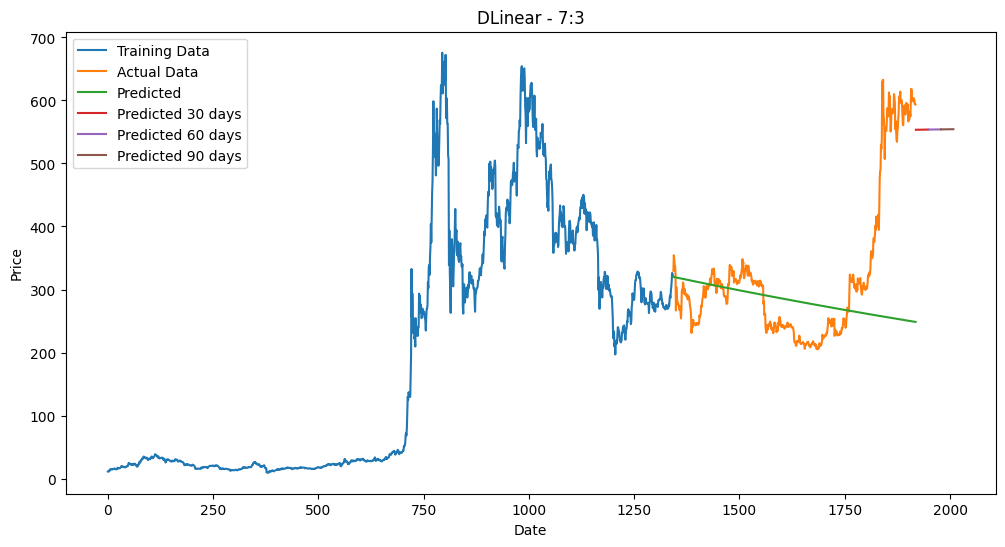

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, predicted_values_test, label='Predicted')
plt.plot(index_future_30,predicted_values_30day, label='Predicted 30 days')
plt.plot(index_future_60,predicted_values_60day, label='Predicted 60 days')
plt.plot(index_future_90,predicted_values_90day, label='Predicted 90 days')
plt.title('DLinear - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

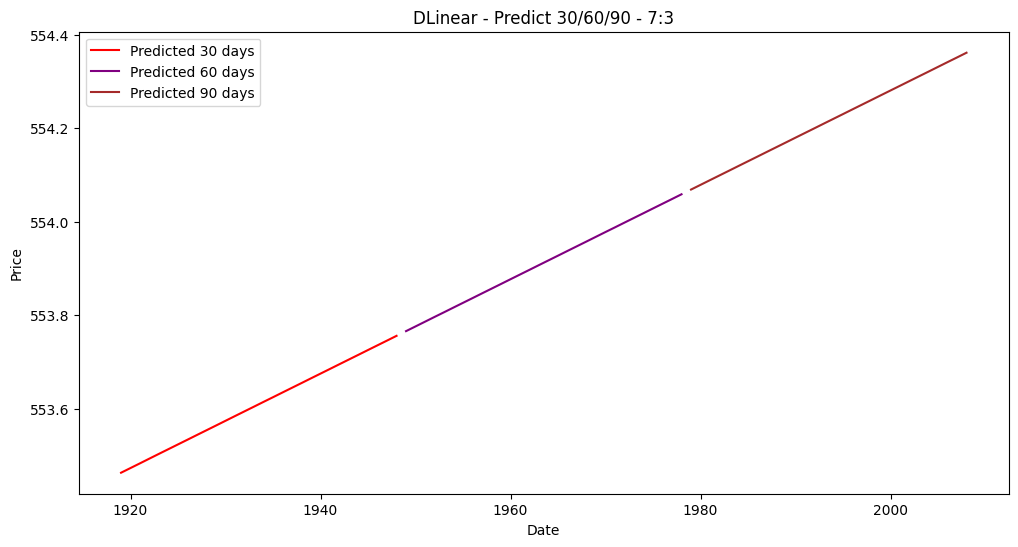

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(index_future_30,predicted_values_30day, label='Predicted 30 days', color='Red')
plt.plot(index_future_60,predicted_values_60day, label='Predicted 60 days', color='Purple')
plt.plot(index_future_90,predicted_values_90day, label='Predicted 90 days', color='Brown')
plt.title('DLinear - Predict 30/60/90 - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
outputs_test = np.array(predicted_values_test)
outputs_test = outputs_test.flatten()
# Tính MAE
mae_test = np.mean(np.abs(test_data - outputs_test))
# Tính MAPE
mape_test = np.mean(np.abs((test_data - outputs_test) / test_data)) * 100
# Tính RMSE
rmse_test = np.sqrt(np.mean((test_data - outputs_test) ** 2))

print("MAE:", mae_test)
print("MAPE:", mape_test)
print("RMSE:", rmse_test)

MAE: 83.11203593677945
MAPE: 21.427161601282187
RMSE: 133.9641534825169
